In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
print("--------------------\nMeasurement Columns\n--------------------")
for c in columns:
    print(c['name'], c["type"])

--------------------
Measurement Columns
--------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
print("----------------\nStation Columns\n----------------")
for c in columns:
    print(c['name'], c["type"])

----------------
Station Columns
----------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

ONE year ago from last data point: 2016-08-23


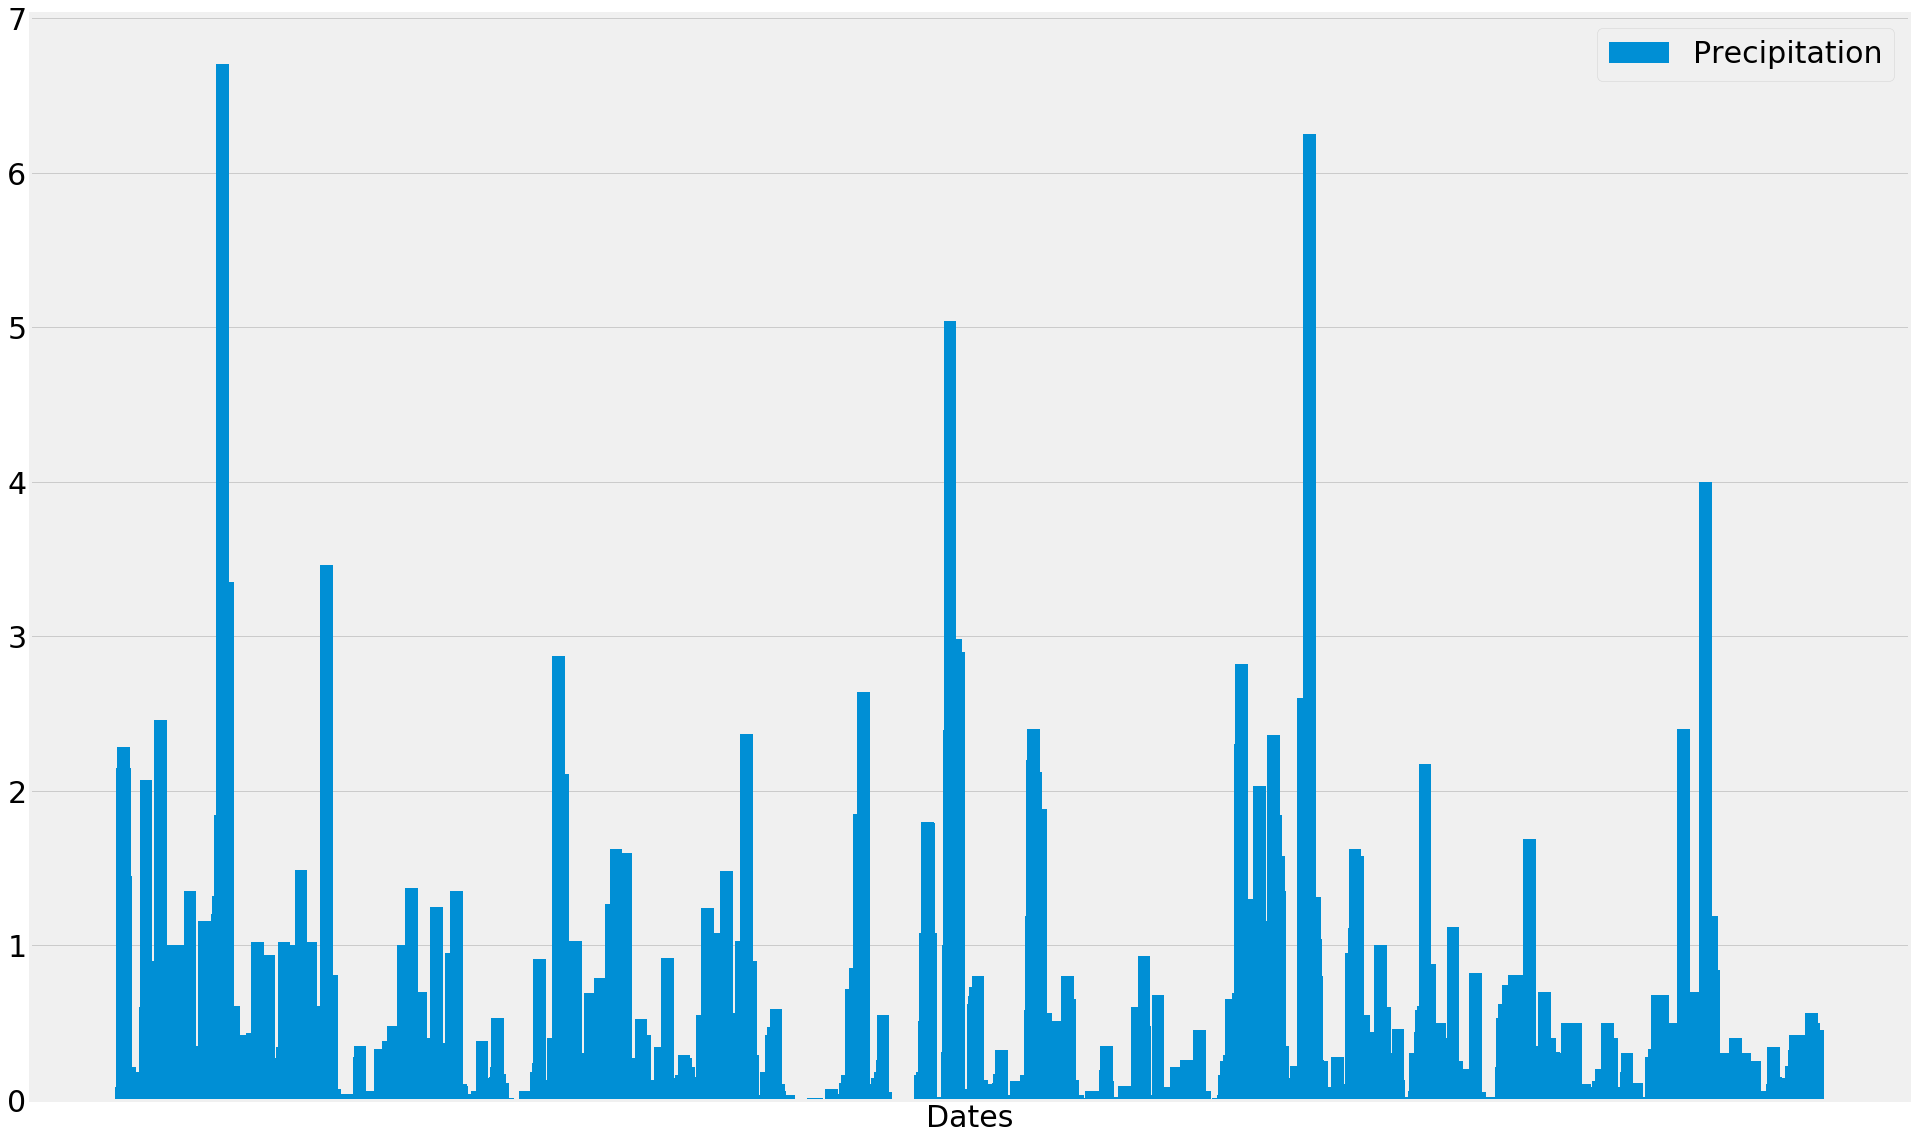

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_list = last_date[0].split('-')
last_year = int(last_date_list[0])
last_month = int(last_date_list[1])
last_day = int(last_date_list[2])

# Calculate the date 1 year ago from the last data point in the database
last_twelve_month = str(dt.date(last_year, last_month, last_day) - dt.timedelta(days = 365))

print(f"ONE year ago from last data point: {last_twelve_month}")

last_twelve_month_list = last_twelve_month.split('-')
last_twelve_year = last_twelve_month_list[0]
last_twelve_month = last_twelve_month_list[1]
last_twelve_day = last_twelve_month_list[2]

# Perform a query to retrieve the data and precipitation scores
last_twelve_months = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > f'{last_twelve_year}-{last_twelve_month}-{last_twelve_day}').\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
date = [value[0] for value in last_twelve_months]
prcp = [value[1] for value in last_twelve_months]

prcp_df = pd.DataFrame({'Dates':date,'Precipitation':prcp})
prcp_df = prcp_df.dropna(how = 'any').set_index("Dates")

# Sort the dataframe by date
prcp_df = prcp_df.sort_index(ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = np.arange(len(prcp_df["Precipitation"]))
y_axis = prcp_df["Precipitation"]

fig, ax = plt.subplots(figsize=(30,20))
ax.bar(x_axis, y_axis, width = 15, label = 'Precipitation')
plt.xticks([], [])
plt.yticks(Fontsize = 30)
plt.xlabel("Dates", Fontsize = 30)
plt.legend(loc = "best", prop={'size': 30})
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement.station).group_by(Measurement.station).count()
stations_count

# Find active stations using Station Table
stations_count = session.query(Station.station).count()
stations_count

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.station, func.count(Station.station)).\
        filter(Measurement.station == Station.station).\
        group_by(Station.station).\
        order_by(func.count(Station.station).desc()).\
        all()

most_active_station = active_stations[0]

print(f"The most active station is {most_active_station[0]} with {most_active_station[1]} counts")

active_stations

The most active station is USC00519281 with 2772 counts


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_records = session.query(func.Min(Measurement.tobs), func.Max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.station == most_active_station[0]).\
        all()

temp_records

[(54.0, 85.0, 71.66378066378067)]

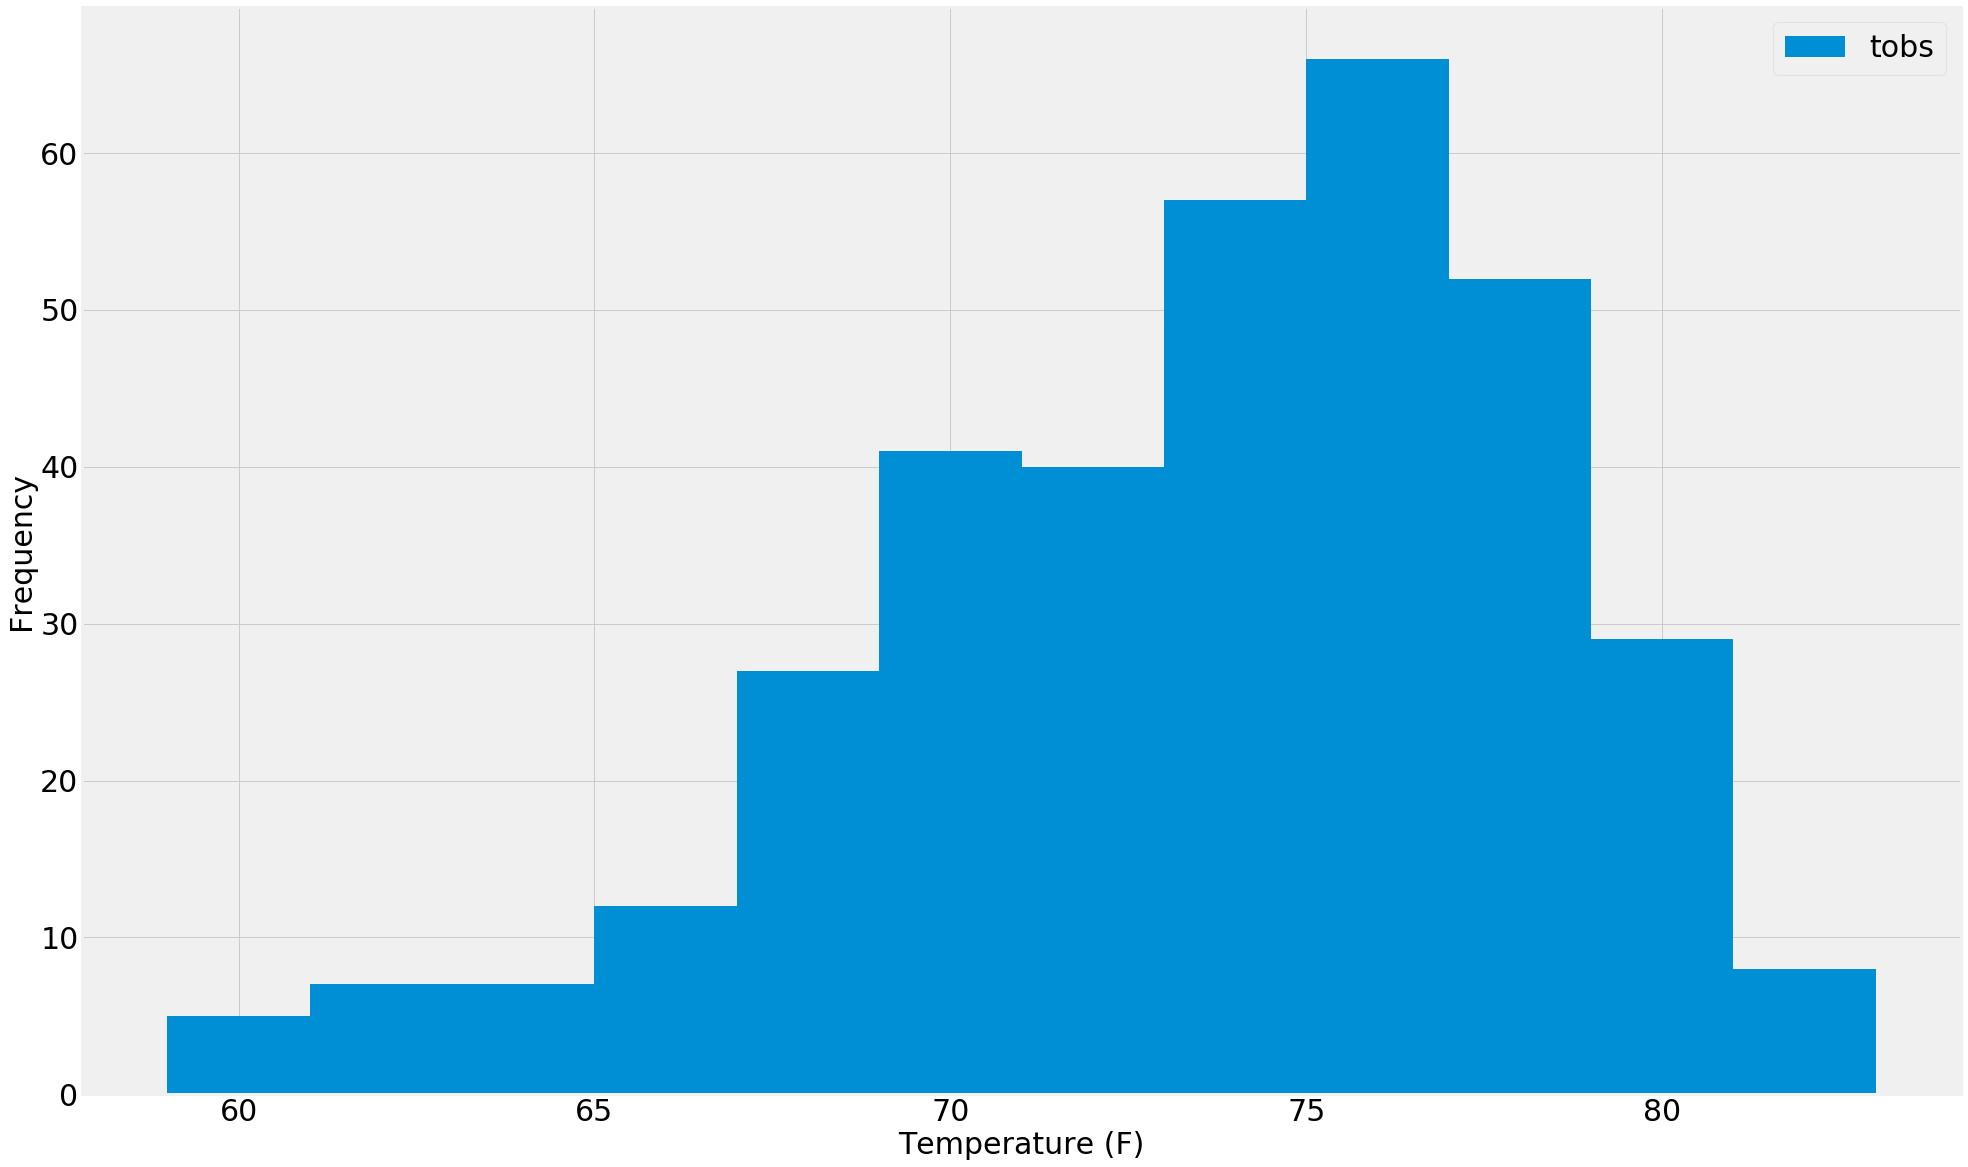

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
obs_data = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.station == most_active_station[0]).\
        filter(Measurement.date > f'{last_twelve_year}-{last_twelve_month}-{last_twelve_day}').\
        all()

date = [data[0] for data in obs_data]
temp = [data[1] for data in obs_data]

fig, ax = plt.subplots(figsize=(30,20))

ax.hist(temp, bins = 12, label = 'tobs')

plt.xlabel("Temperature (F)", Fontsize = 30)
plt.ylabel("Frequency", Fontsize = 30)
plt.xticks(Fontsize = 30)
plt.yticks(Fontsize = 30)
plt.legend(loc = "best", prop={'size': 30})

plt.show()

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2014-08-15', '2014-08-24')
print(trip_temp)

[(69.0, 76.37142857142857, 84.0)]


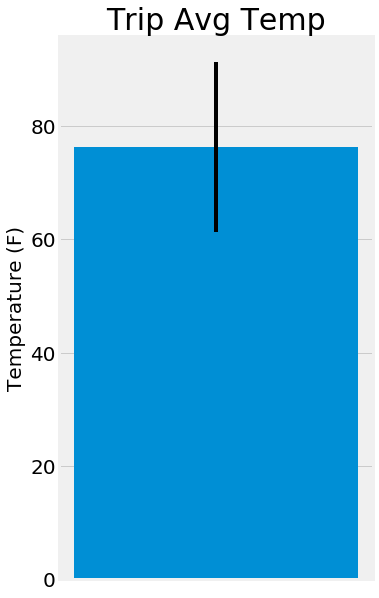

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = trip_temp[0][0]
tmax = trip_temp[0][2]
tavg = trip_temp[0][1]

fig, ax = plt.subplots(figsize=(5,10))
ax.bar(1, tavg, yerr = tmax - tmin)

plt.ylabel("Temperature (F)", Fontsize = 20)
plt.xticks([], [])
plt.yticks(Fontsize = 20)
plt.title("Trip Avg Temp", Fontsize = 30)

plt.show()

In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_data = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
        filter(Station.station == Measurement.station).\
        filter(Measurement.date >= '2014-08-15').filter(Measurement.date <= '2014-08-24').\
        order_by(Measurement.prcp.desc()).\
        all()

for data in trip_data:
    print(data)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.88)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.52)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.37)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.29)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.19)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.18)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.17)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.17)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.16)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.16)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.15)
('USC00514830', 'KUALOA RANCH H

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2014-08-15'
end_date = '2014-08-24'

# Use the start and end date to create a range of dates
trip_dates = session.query(Measurement.date).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Measurement.date).\
        all()

# Stip off the year and save a list of %m-%d strings
def strip(lst):
    new_date = []
    for i in lst:
        strip_date = i[0].split("-")
        new_date.append(strip_date[1] + '-' + strip_date[2])
    return new_date

stripped_dates = strip(trip_dates)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(dates)[0] for dates in stripped_dates]
normals

[(69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0)]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = [dates[0] for dates in trip_dates]

tmin = [i[0] for i in normals]
tmax = [i[2] for i in normals]
tavg = [i[1] for i in normals]

trip_df = pd.DataFrame({'Dates':trip_dates,
             'Temp Min':tmin,
             'Temp Max':tmax,
             'Avg Temp':tavg})

trip_df = trip_df.set_index("Dates")

trip_df

,Temp Min,Temp Max,Avg Temp
Dates,,,
2014-08-15,69.0,83.0,76.471698
2014-08-16,69.0,83.0,76.080000
2014-08-17,69.0,83.0,76.125000
2014-08-18,70.0,84.0,76.923077
2014-08-19,69.0,85.0,75.946429
2014-08-20,68.0,82.0,76.452830
2014-08-21,67.0,83.0,76.400000
2014-08-22,69.0,84.0,76.471698
2014-08-23,67.0,87.0,76.692308


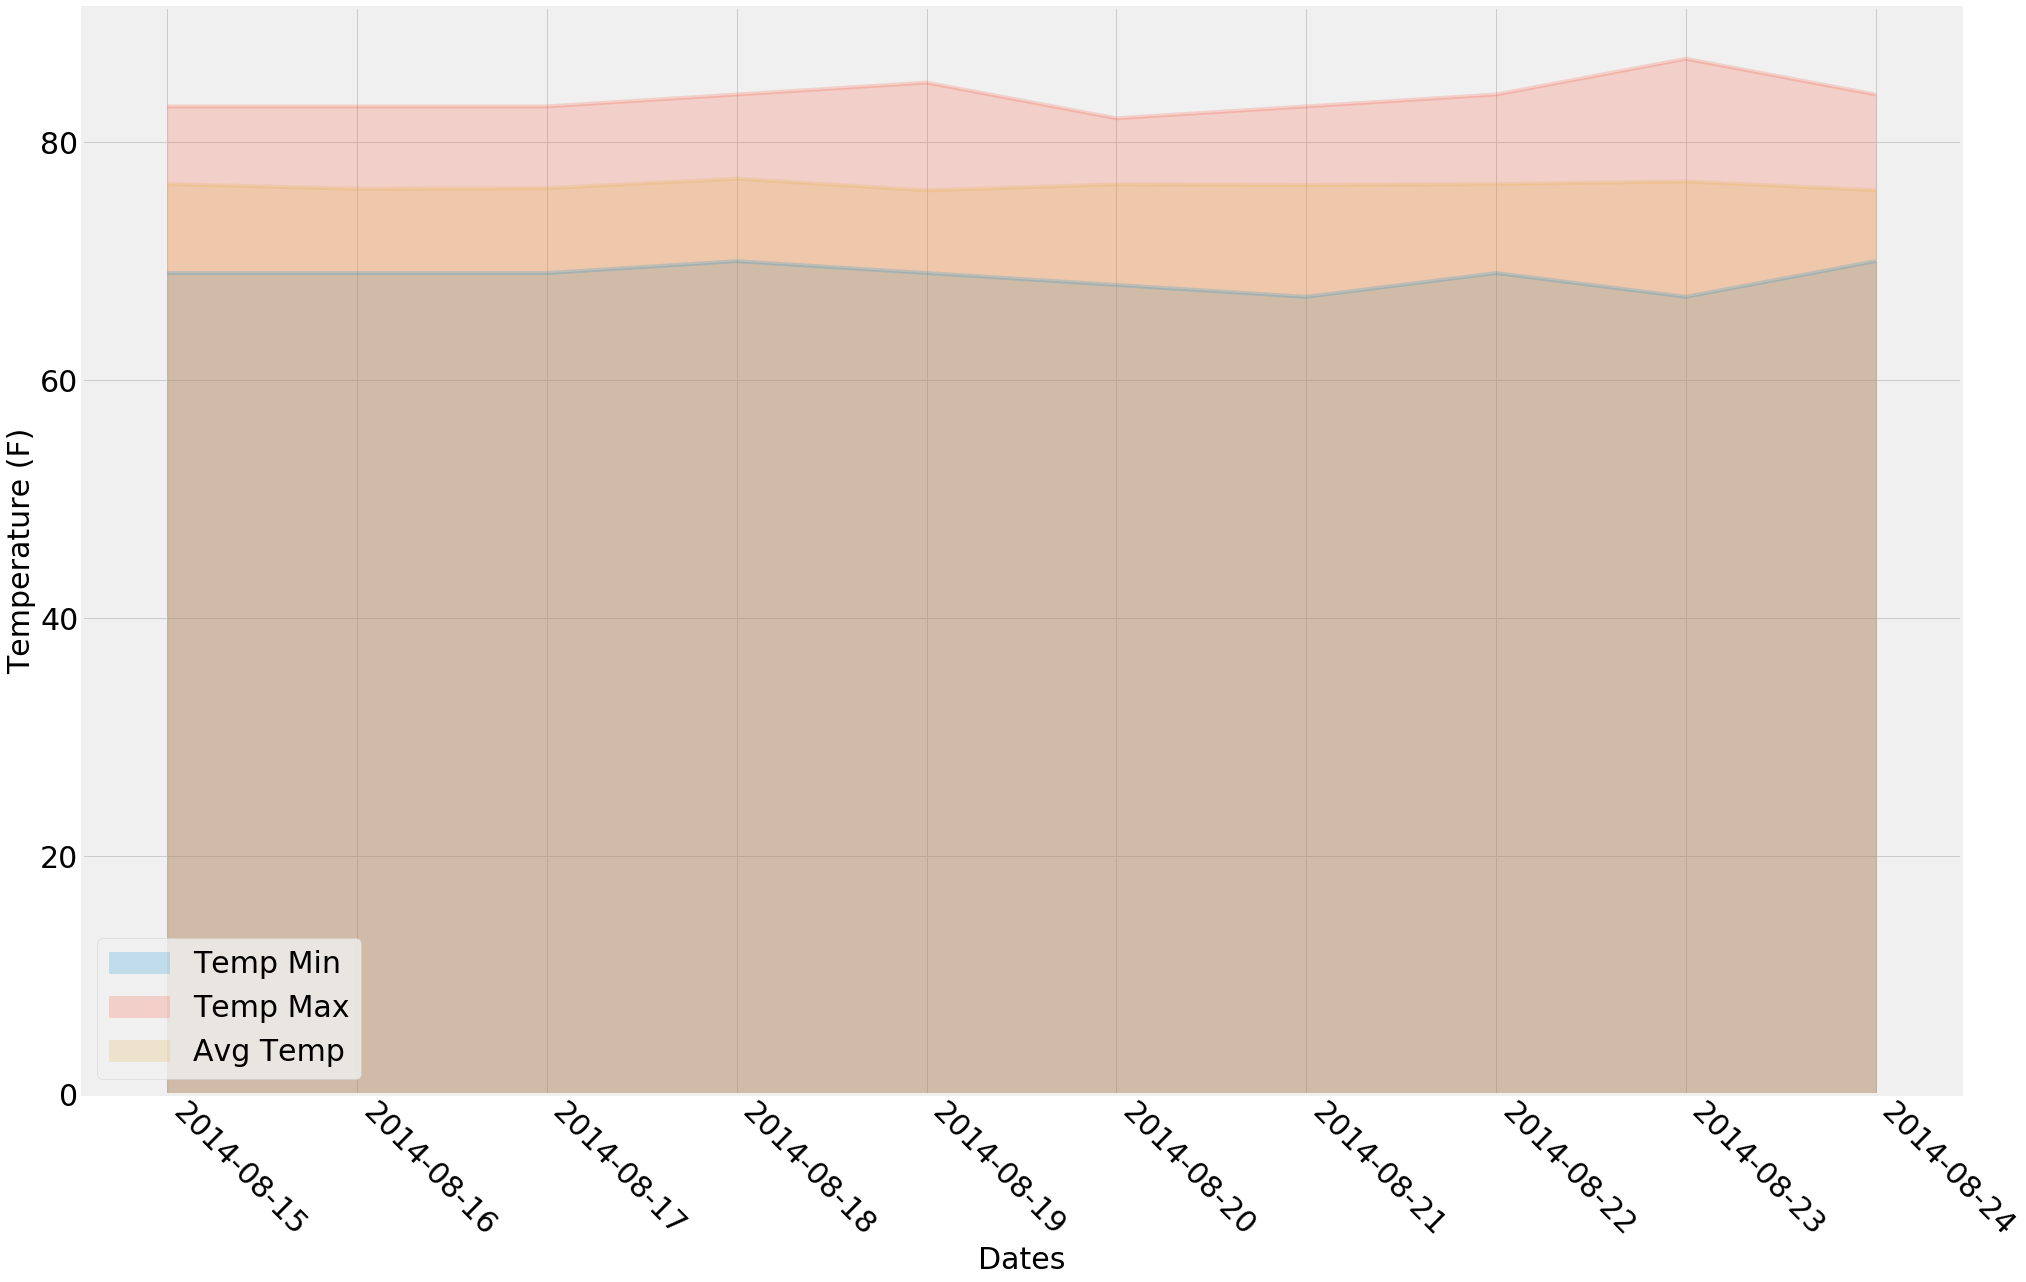

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(figsize=(30,20), stacked=False, alpha = 0.2)

ax = plt.gca()

plt.xticks(np.arange(ax.get_xlim()[0]-ax.get_xlim()[0],ax.get_xlim()[1],1), trip_df.index, Fontsize = 30, rotation = '-45', ha = 'left')
plt.yticks(Fontsize = 30)

plt.xlabel("Dates", Fontsize = 30)
plt.ylabel("Temperature (F)", Fontsize = 30)

plt.legend(loc = "best", prop={'size': 30})

plt.show()

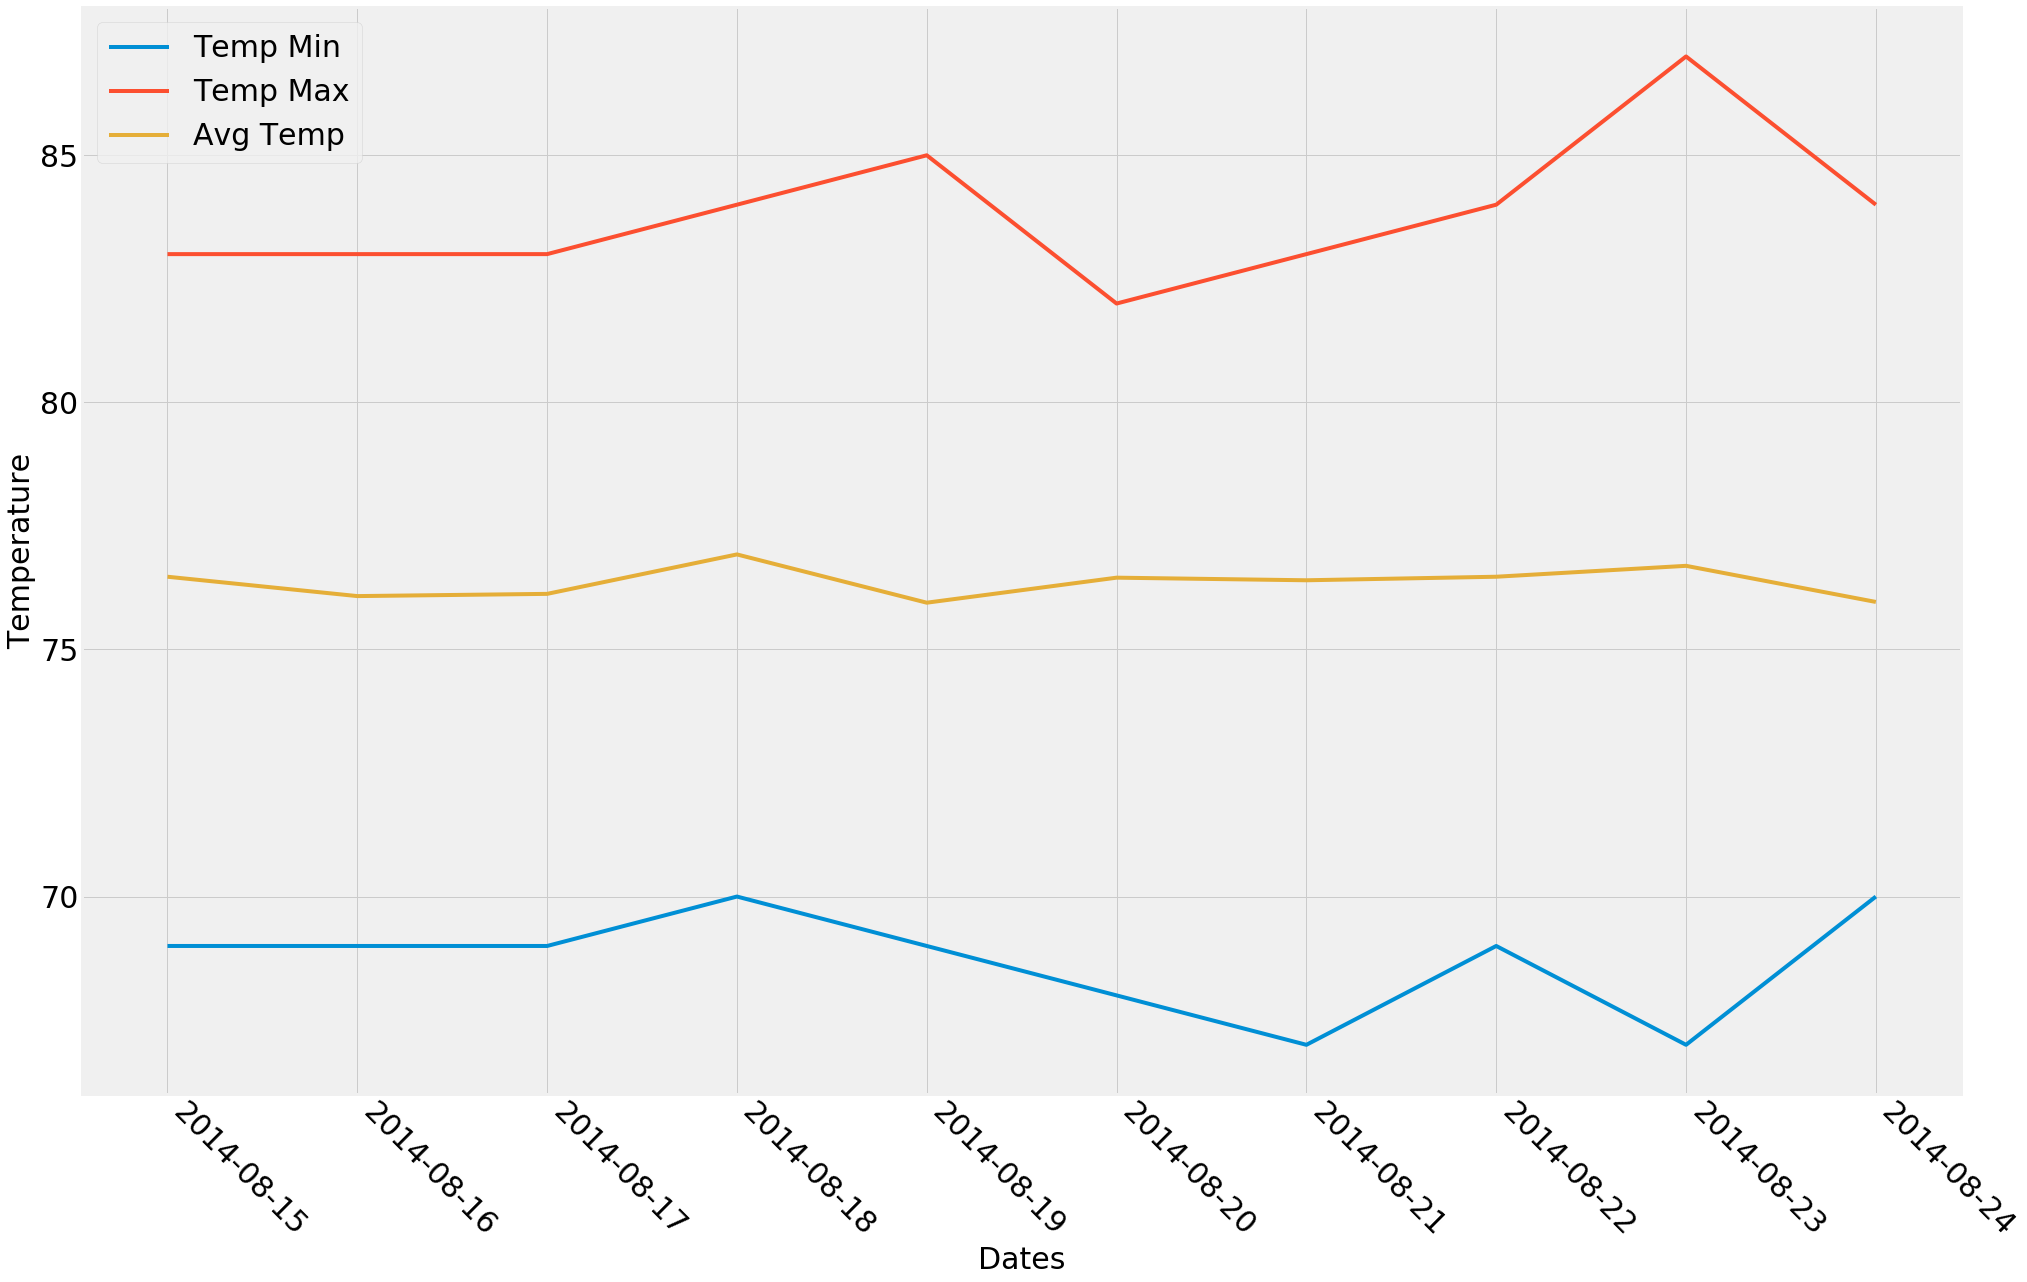

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
x_axis = np.arange(len(trip_df.index))

fig, ax = plt.subplots(figsize=(30,20))

plt.xticks(x_axis, trip_df.index, Fontsize = 30, rotation = '-45', ha = 'left')
plt.yticks(np.arange(0, max(trip_df["Temp Max"]), 5), Fontsize = 30)

plt.xlabel("Dates", Fontsize = 30)
plt.ylabel("Temperature", Fontsize = 30)

for column in trip_df.columns:
    ax.plot(x_axis, trip_df[column], label = column)
    
plt.legend(loc = "best", prop={'size': 30})

plt.show()